In [16]:
import csv
import numpy as np
import pandas as pd

## **Preprocessing data, filtering on (almost) complete survey answers**

In [17]:
df = pd.read_csv('final-data-numeric-aangepaste-antwoorden-kolommen.csv', skiprows=range(1,5)) #rows 1, 2, 3, 4 are skipped, since these don't contain usefull data

df['Progress'] = pd.to_numeric(df['Progress'], errors = 'coerce') #in order to compare to 71

df_preprocessed = df[df['Progress']>=71] #only survey answers with 71% of the questions filled in or higher are considered.

df_preprocessed['Q1'] = df_preprocessed['Q1'].replace({1.0: 0, 2.0:1}) #change into binary variable with 0's and 1's. 0=teacher, 1=student


df_preprocessed['Q10.1'] = df_preprocessed['Q10.1'].replace({1.0:0, 4.0:1, 5.0:2, 6.0:3, 7.0:4, 8.0:5 })

#categorise age variable:
df_preprocessed['Q2'] = pd.to_numeric(df_preprocessed['Q2'], errors = 'coerce')

df_preprocessed['Q2'] = pd.cut(
    df_preprocessed['Q2'],
    bins=[18, 25, 35, 50, float('inf')],
    labels=[0,1,2,3], #specify in results section that 0 = young adults, 1 = early adults, 2 = adults, 4 = older adults.
    include_lowest=True,
    right=False)

#combining educational programme of teachers and students into 1 column:
role_col = 'Q1'
teacher_programme_col = 'Q3'
student_programme_col = 'Q7'
new_programme_col = 'Educational Programme'

df_preprocessed[new_programme_col] = pd.NA

teacher_code = 0
student_code = 1

if teacher_programme_col in df_preprocessed.columns:
    df_preprocessed.loc[df_preprocessed[role_col] == teacher_code, new_programme_col] = df_preprocessed[teacher_programme_col]

if student_programme_col in df_preprocessed.columns:
     df_preprocessed.loc[df_preprocessed[role_col] == student_code, new_programme_col] = df_preprocessed[student_programme_col]


# #Excluding psychology and pedagogical sciences from data set since no respondents filled this in as educational programme
# excluded_programmes = [3.0, 5.0]

#df to np array:
data = df_preprocessed.to_numpy()

/tmp/ipykernel_3032/1912229762.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed['Q1'] = df_preprocessed['Q1'].replace({1.0: 0, 2.0:1}) #change into binary variable with 0's and 1's. 0=teacher, 1=student
/tmp/ipykernel_3032/1912229762.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed['Q10.1'] = df_preprocessed['Q10.1'].replace({1.0:0, 4.0:1, 5.0:2, 6.0:3, 7.0:4, 8.0:5 })
/tmp/ipykernel_3032/1912229762.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [18]:
#question numbers and their corresponding column number for easily accesing questions
q = {1:10, 2:11, 3:12, 4:14, 5:15, 6:16, 7:17, 8:19, 9:20, 10:21, 11:23,
     12:24, 13:25, 14:26, 15:27, 16:28, 17:29, 18:30, 19:31, 20:32, 21:33,
     22:34, 23:35, 24:36, 25:37, 26:38, 27:39, 28:40, 29:41, 30:42, 31:43, 32:45, 33:47}
#33 = combined educational programmes for teachers and students

### **Check filled fields of data**
Making sure data is usable for applying Ordinal Regression Analysis

In [19]:
def check_fields(fields, data):
    relevant_data = data[:, fields] #instead of: filtered_data = data.copy(), since I only need the data of the specific fields
    valid_idx = np.ones((data.shape[0])) #create array of 1's corresponding to amount of rows in data
    for f in fields:
        valid_idx[np.logical_or(data[:, f]=='', np.isnan(data[:, f].astype(float)))] = 0 #if field is not filled in, assign a 0, such that it is not considered in the regression analysis.
    return relevant_data[valid_idx==1] #return the data where the fields needed for the regression analysis are all filled in

## **Ordinal Multiple Regression**
I will perform various ordinal multiple regression analyses with various dependent and independent variables.

<!-- For each analysis I will also perform a Brant test to test for the proportional odds assumption. -->

<!-- https://medium.com/evangelinelee/brant-test-for-proportional-odds-in-r-b0b373a93aa2
Brant paper: https://www.jstor.org/stable/2532457?origin=crossref&seq=1#page_scan_tab_contents
Testing data for proportional odds assumption (=assesses whether the observed deviations from our Ordinal Logistic Regression model are larger than what could be attributed to chance alone. ) -->

In [20]:
import scipy.stats as stats
from statsmodels.miscmodels.ordinal_model import OrderedModel
#Assume logit as link function in regression -> https://medium.com/@jumbongjunior1999/ordinal-logistic-regression-in-python-and-r-f6ee05d48d16
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import exp

In [21]:
#functions to obtain predicted probabilities:  exp(αj - (β1X1 + β2X2 + ...)) / (1 + exp(αj - (β1X1 + β2X2 + ...)))
#only later found out .predict() exists and does the same.

def sum(res_log, filtered_var_data):
    result = 0 
    for i, var in enumerate(filtered_var_data):
        result = result + (res_log.params[i] * var)
    return result


def cumulative_probs(thresholds, sum):
    cum_probs = []
    for threshold in thresholds:
        odds_ratio = exp(threshold - sum)
        prob = odds_ratio / (1 + odds_ratio)
        cum_probs.append(prob)

    return cum_probs

def category_probs(cumulative_probs, thresholds):
    cat_probs = []
    cat_probs.append(cumulative_probs[0]) #1st cumulative probability is only about category 1, so that is also the first category probability
    for i in range(1, len(cumulative_probs)):
        cat_probs.append(cumulative_probs[i] - cumulative_probs[i-1])
    cat_probs.append(1 - cumulative_probs[-1]) #last category prob is 1 minus the last cumulative prob

    return cat_probs

def predicted_probabilities(res_log, filtered_var_data, thresholds):
    result_sum = sum(res_log, filtered_var_data)
    thresholds_w_inf = thresholds[1:-1]
    cum_probs = cumulative_probs(thresholds_w_inf, result_sum)
    return category_probs(cum_probs, thresholds_w_inf)



In [22]:
#Plotting preparation
def get_group_probs(predicted_probabilities, data, cat_id, cat_val):
    group_bool = data[:, cat_id] == cat_val
    group_probs = []
    for response_cat_array in predicted_probabilities:
        filtered_group_cat = response_cat_array[group_bool]
        group_probs.append(filtered_group_cat)
    return group_probs

def get_group_std(group_probs):
    group_std = []
    for response_cat_array in group_probs:
        group_std.append(np.std(response_cat_array))
        
    return group_std

def get_group_mean(group_probs):
    group_mean = []
    for response_cat_array in group_probs:
        group_mean.append(np.mean(response_cat_array))
    return group_mean

## **Respondent Demographics**

**Respondent amounts**

/tmp/ipykernel_3032/3031269587.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x = values, y = [teacher_amount, student_amount], palette = colors)


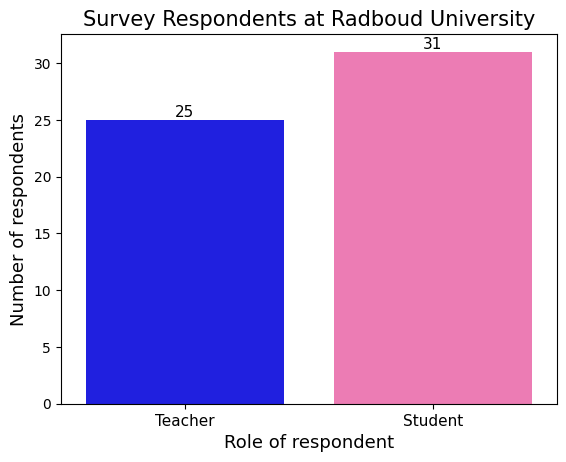

In [23]:
roles = data[:, q[1]]

teacher_amount = np.sum(roles == 0)
student_amount = np.sum(roles == 1)

colors = ['blue', 'hotpink']
values = ['Teacher', 'Student']

# print(teacher_amount)
# print(student_amount)

ax = sns.barplot(x = values, y = [teacher_amount, student_amount], palette = colors)
ax.tick_params(axis='x', labelsize=11)


#adding amounts on top of bars:
for i, value in enumerate([teacher_amount, student_amount]):
    ax.annotate(str(value), xy=(i, value), fontsize = 11, ha='center', va='bottom')

plt.xlabel("Role of respondent", fontsize = 13)
plt.ylabel("Number of respondents", fontsize = 13)
ax.set_title("Survey Respondents at Radboud University", fontsize = 15)

plt.savefig('demographics_respondent_amount.png')
plt.savefig('demographics_respondent_amount.eps')

plt.tight_layout
plt.show()

**Age distribution**

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


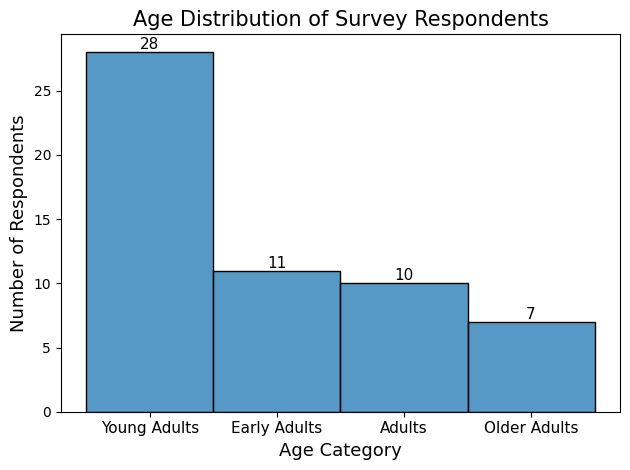

In [24]:
ages = data[:, q[2]]

age_categories = ['Young Adults', 'Early Adults', 'Adults', 'Older Adults']

ya_amount = np.sum(ages == 0)
ea_amount = np.sum(ages == 1)
a_amount = np.sum(ages == 2)
oa_amount = np.sum(ages == 3)

ax = sns.histplot(ages, discrete=True)

ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(age_categories)
ax.tick_params(axis='x', labelsize=11)

for i, value in enumerate([ya_amount, ea_amount, a_amount, oa_amount]):
    ax.annotate(str(value), xy=(i, value), ha='center', va='bottom', fontsize = 11)

plt.xlabel("Age Category", fontsize = 13)
plt.ylabel("Number of Respondents", fontsize = 13)
plt.title("Age Distribution of Survey Respondents", fontsize = 15)

plt.savefig('demographics_age_category_distribution.png')
plt.savefig('demographics_age_category_distribution.eps')

plt.tight_layout()
plt.show()



#add ages histogram and add this plot as subplot if time left
#explain why i chose the categories - either methods or discussion

In [25]:
import textwrap

def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width, break_long_words=break_long_words))
    ax.set_xticklabels(labels)

**Educational progamme distribution - Teachers**

/tmp/ipykernel_3032/2564439780.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=labels_education, palette=dict(zip(filtered_programme_labels, filtered_colors)), order=filtered_programme_labels)


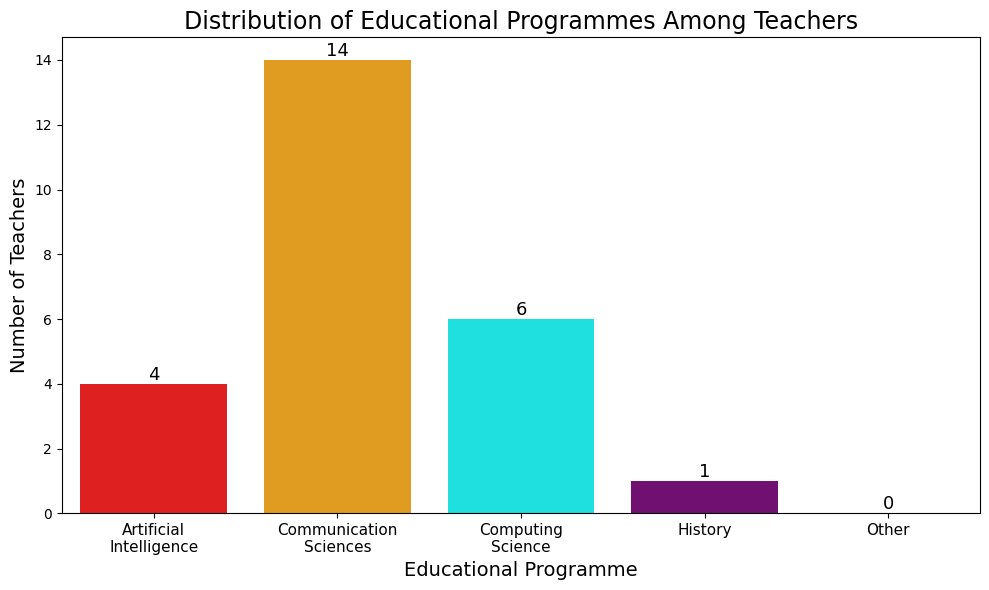

In [26]:
educational_programmes_teachers = data[:, q[3]]

programme_labels = ['Artificial Intelligence', 'Communication Sciences', 'Psychology', 'Computing Science', 'Pedagogical Sciences', 'History', 'Other']
colors = ['Red', 'Orange', 'Green', 'Cyan', 'Yellow', 'Purple', 'Magenta']


excluded_labels = ['Psychology', 'Pedagogical Sciences']
excluded_codes = [3.0, 5.0]

filtered_programme_labels = [label for label in programme_labels if label not in excluded_labels]
filtered_colors = [col for label, col in zip(programme_labels, colors) if label not in excluded_labels]

code_to_label_map = {float(i+1): label for i, label in enumerate(programme_labels)}

labels_education = []

for teacher_code in educational_programmes_teachers:
    if pd.isna(teacher_code) or teacher_code in excluded_codes:
        continue

    label = code_to_label_map.get(teacher_code)

    if label:
        labels_education.append(label)
    

plt.figure(figsize=(10, 6))

ax = sns.countplot(x=labels_education, palette=dict(zip(filtered_programme_labels, filtered_colors)), order=filtered_programme_labels)

ax.set_xticks(range(len(filtered_programme_labels)))
wrap_labels(ax, 10)
ax.tick_params(axis='x', labelsize=11)

teacher_programme_amounts = {}
for label in filtered_programme_labels:
    teacher_programme_amounts[label] = labels_education.count(label)

for i, label in enumerate(filtered_programme_labels):
    count = teacher_programme_amounts[label]
    ax.annotate(str(count), xy=(i, count), ha='center', va='bottom', fontsize = 13)

plt.xlabel("Educational Programme", fontsize = 14)
plt.ylabel("Number of Teachers", fontsize = 14)
plt.title("Distribution of Educational Programmes Among Teachers", fontsize = 17)

plt.savefig('demographics_teacher_edu_prog_distribution.png')
plt.savefig('demographics_teacher_edu_prog_distribution.eps')


plt.tight_layout()
plt.show()

**Educational programmes distribution - Students**

/tmp/ipykernel_3032/740772339.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=labels_education, palette=dict(zip(filtered_programme_labels, filtered_colors)), order=filtered_programme_labels)


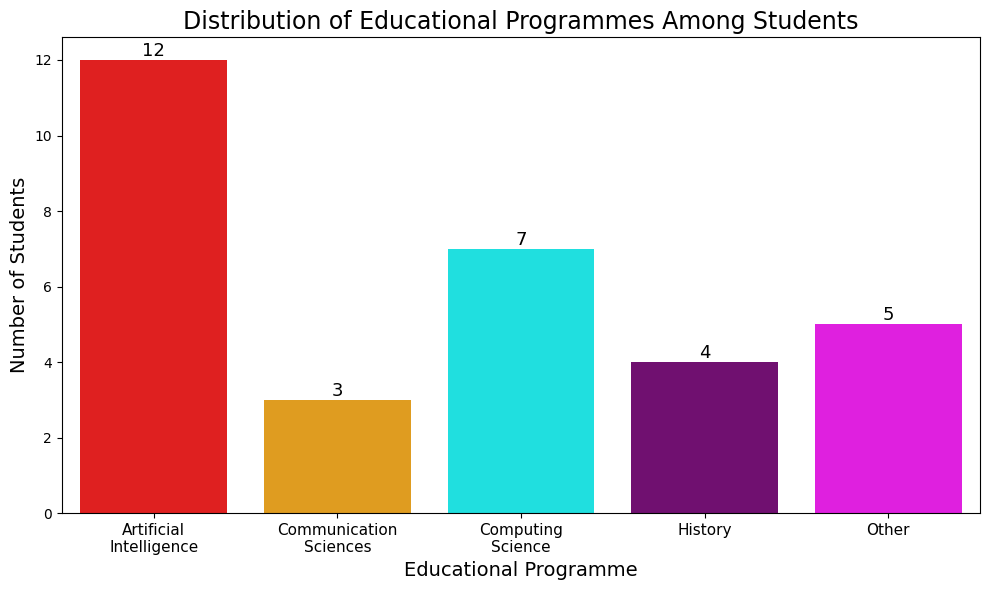

In [27]:
educational_programmes_students = data[:, q[7]]

# print(educational_programmes_students)

programme_labels = ['Artificial Intelligence', 'Communication Sciences', 'Psychology', 'Computing Science', 'Pedagogical Sciences', 'History', 'Other']
colors = ['Red', 'Orange', 'Green', 'Cyan', 'Yellow', 'Purple', 'Magenta']

excluded_labels = ['Psychology', 'Pedagogical Sciences']
excluded_codes = [3.0, 5.0]

filtered_programme_labels = [label for label in programme_labels if label not in excluded_labels]
filtered_colors = [col for label, col in zip(programme_labels, colors) if label not in excluded_labels]

code_to_label_map = {float(i+1): label for i, label in enumerate(programme_labels)}

labels_education = []
for student_code in educational_programmes_students:
    if pd.isna(student_code) or student_code in excluded_codes:
        continue

    label = code_to_label_map.get(student_code)

    if label:
        labels_education.append(label)

# print(labels_education)

plt.figure(figsize=(10, 6))

ax = sns.countplot(x=labels_education, palette=dict(zip(filtered_programme_labels, filtered_colors)), order=filtered_programme_labels)

ax.set_xticks(range(len(filtered_programme_labels)))
wrap_labels(ax, 10)
ax.tick_params(axis='x', labelsize=11)

student_programme_amounts = {}
for label in filtered_programme_labels:
    student_programme_amounts[label] = labels_education.count(label)

for i, label in enumerate(filtered_programme_labels):
    count = student_programme_amounts[label]
    ax.annotate(str(count), xy=(i, count), ha='center', va='bottom', fontsize = 13)

plt.xlabel("Educational Programme", fontsize = 14)
plt.ylabel("Number of Students", fontsize = 14)
plt.title("Distribution of Educational Programmes Among Students", fontsize = 17)

plt.savefig('demographics_student_edu_prog_distribution.png')
plt.savefig('demographics_student_edu_prog_distribution.eps')




plt.tight_layout()
plt.show()

**Amount of LLM users**

/tmp/ipykernel_3032/3417026074.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x=values, y=teacher_counts, palette=teacher_colors, ax=axes[0])
/tmp/ipykernel_3032/3417026074.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x=values, y=student_counts, palette=student_colors, ax=axes[1])


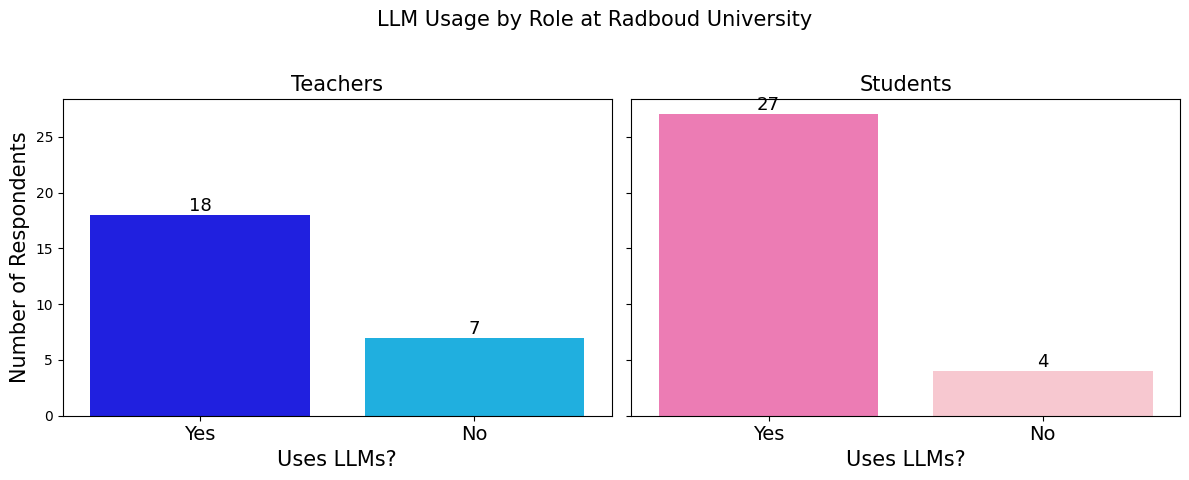

In [28]:
role = data[:, q[1]]
llm_users = data[:, q[12]]

teachers = (role == 0)
students = (role == 1)

teacher_llm_usage = llm_users[teachers]
student_llm_usagge = llm_users[students]

teacher_yes_count = np.sum(teacher_llm_usage == 1)
teacher_no_count = np.sum(teacher_llm_usage == 2)

student_yes_count = np.sum(student_llm_usagge == 1)
student_no_count = np.sum(student_llm_usagge == 2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharey=True)
fig.suptitle("LLM Usage by Role at Radboud University", fontsize = 15) #this can both be for education or personal use -> add in plot?

values = ['Yes', 'No'] 
teacher_colors = ['blue', 'deepskyblue']
student_colors = ['hotpink', 'pink']

teacher_counts = [teacher_yes_count, teacher_no_count]
ax1 = sns.barplot(x=values, y=teacher_counts, palette=teacher_colors, ax=axes[0])
ax1.set_title("Teachers", fontsize = 15)
ax1.set_xlabel("Uses LLMs?", fontsize = 15)
ax1.set_ylabel("Number of Respondents", fontsize = 15)
ax1.tick_params(axis='x', labelsize=14)

for i, value in enumerate(teacher_counts):
    ax1.annotate(str(value), xy=(i, value), ha='center', va='bottom', fontsize = 13)

student_counts = [student_yes_count, student_no_count]
ax2 = sns.barplot(x=values, y=student_counts, palette=student_colors, ax=axes[1])
ax2.set_title("Students", fontsize = 15)
ax2.set_xlabel("Uses LLMs?", fontsize = 15)
ax2.tick_params(axis='x', labelsize=14)

for i, value in enumerate(student_counts):
    ax2.annotate(str(value), xy=(i, value), ha='center', va='bottom', fontsize = 13)

plt.savefig('demographics_llm_users.png')
plt.savefig('demographics_llm_users.eps')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


**Amount of AI tool users (other than llms)**

/tmp/ipykernel_3032/3921074613.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x=values, y=teacher_counts, palette=teacher_colors, ax=axes[0])
/tmp/ipykernel_3032/3921074613.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x=values, y=student_counts, palette=student_colors, ax=axes[1])


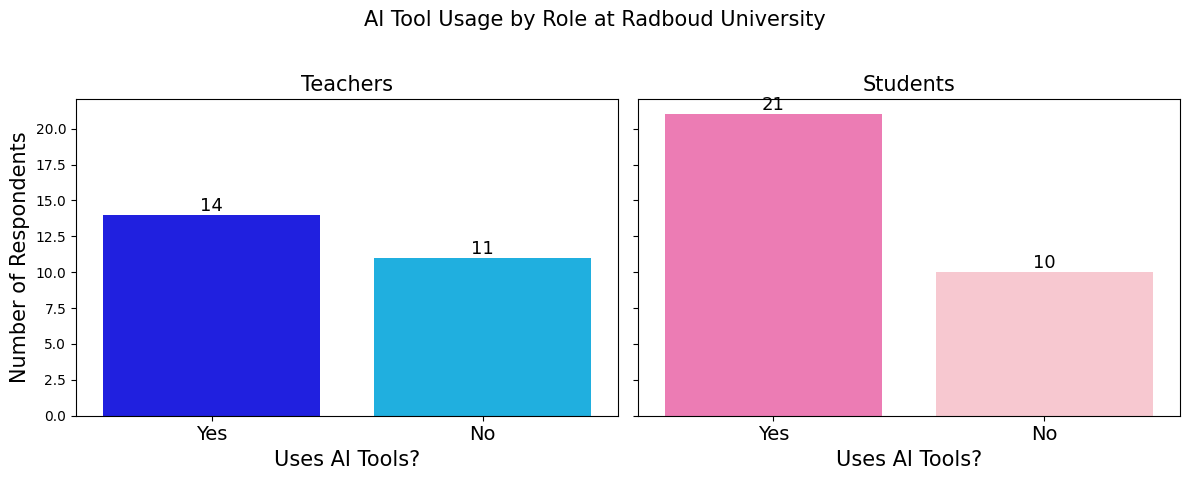

In [29]:
role = data[:, q[1]]
ai_tool_users = data[:, q[15]]

teachers = (role == 0)
students = (role == 1)

teacher_ai_tool_usage = ai_tool_users[teachers]
student_ai_tool_usage = ai_tool_users[students]

teacher_yes_count = np.sum(teacher_ai_tool_usage == 1)
teacher_no_count = np.sum(teacher_ai_tool_usage == 2)

student_yes_count = np.sum(student_ai_tool_usage == 1)
student_no_count = np.sum(student_ai_tool_usage == 2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharey=True)
fig.suptitle("AI Tool Usage by Role at Radboud University", fontsize = 15) #this can both be for education or personal use -> add in plot?

values = ['Yes', 'No'] 
teacher_colors = ['blue', 'deepskyblue']
student_colors = ['hotpink', 'pink']

teacher_counts = [teacher_yes_count, teacher_no_count]
ax1 = sns.barplot(x=values, y=teacher_counts, palette=teacher_colors, ax=axes[0])
ax1.set_title("Teachers", fontsize = 15)
ax1.set_xlabel("Uses AI Tools?", fontsize = 15)
ax1.set_ylabel("Number of Respondents", fontsize = 15)
ax1.tick_params(axis='x', labelsize=14)

for i, value in enumerate(teacher_counts):
    ax1.annotate(str(value), xy=(i, value), ha='center', va='bottom', fontsize = 13)

student_counts = [student_yes_count, student_no_count]
ax2 = sns.barplot(x=values, y=student_counts, palette=student_colors, ax=axes[1])
ax2.set_title("Students", fontsize = 15)
ax2.set_xlabel("Uses AI Tools?", fontsize = 15)
ax2.tick_params(axis='x', labelsize=14)

for i, value in enumerate(student_counts):
    ax2.annotate(str(value), xy=(i, value), ha='center', va='bottom', fontsize = 13)

plt.savefig('demographics_AI_tool_users.png')
plt.savefig('demographics_AI_tool_users.eps')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## **Results**

In [ ]:
from pybrant import BrantPy

def test_proportional_odds(model_result, with_formula=False, var_names=None, print_summary=True):    
    if not hasattr(model_result.model, 'data'):
        model_result.model.data = type('data', (), {})()
    
    if var_names is None:
        var_names = [f'var{i}' for i in range(model_result.model.exog.shape[1])]
    
    exog_df = pd.DataFrame(
        model_result.model.exog,
        columns=var_names
    )
    
    model_result.model.data.orig_exog = exog_df
    
    brant_test = BrantPy(model=model_result, with_formula=with_formula)
    test_results = brant_test.TestResults()
    
    if print_summary:
        print(brant_test.summary())
    
    return test_results

### **Analysis 1:** Q11: How familiar are you with AI? = dependent var.
independent var = q1 & (q3 & q7 = q33) & q2

In [ ]:
filtered_data_a1 = check_fields([q[11], q[1], q[2], q[33]], data) #a1 stands for analysis 1. q[11]=ai familiarity dep var, q[1] = role, 

#Ordinal regression Q11
mod_log_a1 = OrderedModel(filtered_data_a1[:, 0].astype(int), filtered_data_a1[:, [1, 2, 3]].astype(int), distr='logit')
#Check whether Ordered model are looking at rows = answers and columns is variables -> then transpose. 
# this checks out
res_log_a1 = mod_log_a1.fit(method = 'bfgs', disp=False)

results_a1 = test_proportional_odds(res_log_a1, var_names=["Role", "Age", "Education"])
res_log_a1.summary()



Brant Test of Parallel Regression Assumption
Model type: Array-based
Number of observations: 56
Number of predictors: 3
Number of outcome levels: 5
--------------------------------------------------

Test Results:

 Variable   Chi-square  df      p-value
  Omnibus      675.743   9        0.000
     Role     -295.665   3        1.000
      Age       27.373   3        0.000
Education        5.807   3        0.121

--------------------------------------------------

Interpretation:
* H0: Parallel Regression Assumption holds
* P-value < 0.05 suggests violation of the parallel regression assumption
* Omnibus test examines global validity of the assumption
* Individual tests identify specific problematic variables



<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -69.266
Model:                   OrderedModel   AIC:                             152.5
Method:            Maximum Likelihood   BIC:                             166.7
Date:                Mon, 21 Apr 2025                                         
Time:                        12:35:06                                         
No. Observations:                  56                                         
Df Residuals:                      49                                         
Df Model:                           3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8894      0.843      1.055      0.291      -0.763       2.542
x2             0.1299      0.382      0.340      0.734      -0.618       0.878
x3            -0.2936      0.135     -2.181      0.029      -0.557      -0.030
1/2           -3.2798      1.021     -3.214      0.001      -5.280      -1.280
2/3            0.6988      0.280      2.495      0.013       0.150       1.248
3/4           -0.0629      0.279     -0.225      0.822      -0.609       0.484
4/5            1.2741      0.209      6.105      0.000       0.865       1.683
==============================================================================
"""

### **Analysis 2:** dep var = Q13: How often do you make use of ChatGPT (or other similar LLMs) in education? **1=** Never, **2=** Rarely, **3=** Sometimes, **4=** Often, **5=** Very often\
independent var = q1 & (q3 & q7 = q33) & q2

Only for people who filled in that they use chatgpt (so answered yes to Q12, plot in demographics)


In [ ]:
filtered_data_a2 = check_fields([q[13], q[1], q[2], q[33]], data) #a1 stands for analysis 1. q[11]=ai familiarity dep var, q[1] = role, 

#Ordinal regression Q11
mod_log_a2 = OrderedModel(filtered_data_a2[:, 0].astype(int), filtered_data_a2[:, [1, 2, 3]].astype(int), distr='logit')
#Check whether Ordered model are looking at rows = answers and columns is variables -> then transpose. 
# this checks out
res_log_a2 = mod_log_a2.fit(method = 'bfgs', disp=False)
results_a2 = test_proportional_odds(res_log_a2, var_names=["Role", "Age", "Education"])
res_log_a2.summary()

ValueError: array must not contain infs or NaNs

### **Analysis** 3: dep var = **Q16**: How often do you make use of AI tools - other than ChatGPT and other LLMs - in education (e.g. grammar correction tools (Grammarly), personalised learning environments, grading assistants, automated feedback systems)? **1=** Never, **2=** Rarely, **3=** Sometimes, **4=** Often, **5=** Very often\
independent var = q1 & (q3 & q7 = q33) & q2

Only for people who filled in that they use ai tools other than llms (so answered yes to Q15, plot in demographics)


In [ ]:
filtered_data_a3 = check_fields([q[16], q[1], q[2], q[33]], data) #a1 stands for analysis 1. q[11]=ai familiarity dep var, q[1] = role, 

#Ordinal regression Q11
mod_log_a3 = OrderedModel(filtered_data_a3[:, 0].astype(int), filtered_data_a3[:, [1, 2, 3]].astype(int), distr='logit')
#Check whether Ordered model are looking at rows = answers and columns is variables -> then transpose. 
# this checks out
res_log_a3 = mod_log_a3.fit(method = 'bfgs', disp=False)
results_a3 = test_proportional_odds(res_log_a3, var_names=["Role", "Age", "Education"])
res_log_a3.summary()


Brant Test of Parallel Regression Assumption
Model type: Array-based
Number of observations: 35
Number of predictors: 3
Number of outcome levels: 5
--------------------------------------------------

Test Results:

 Variable   Chi-square  df      p-value
  Omnibus       -8.869   9        1.000
     Role       -5.722   3        1.000
      Age       24.838   3        0.000
Education        0.173   3        0.982

--------------------------------------------------

Interpretation:
* H0: Parallel Regression Assumption holds
* P-value < 0.05 suggests violation of the parallel regression assumption
* Omnibus test examines global validity of the assumption
* Individual tests identify specific problematic variables



<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -53.079
Model:                   OrderedModel   AIC:                             120.2
Method:            Maximum Likelihood   BIC:                             131.0
Date:                Mon, 21 Apr 2025                                         
Time:                        10:36:29                                         
No. Observations:                  35                                         
Df Residuals:                      28                                         
Df Model:                           3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.6845      1.089     -0.629      0.530      -2.819       1.450
x2            -0.2246      0.496     -0.453      0.651      -1.197       0.748
x3            -0.1799      0.186     -0.970      0.332      -0.544       0.184
1/2           -2.7124      1.115     -2.432      0.015      -4.898      -0.527
2/3            0.3866      0.290      1.333      0.183      -0.182       0.955
3/4            0.0051      0.324      0.016      0.987      -0.629       0.639
4/5            0.4846      0.342      1.417      0.156      -0.186       1.155
==============================================================================
"""

### **Analysis** 4: dep var = ***Q20**: What is your level of confidence in the accuracy/correctness of the content when looking at a text output from ChatGPT (or other similar LLMs) when the text output is a modified version of a source text: (1: not confident; 5: very confident)\
independent var = q1 & (q3 & q7 = q33) & q2


In [ ]:
filtered_data_a4 = check_fields([q[20], q[1], q[2], q[33]], data) #a1 stands for analysis 1. q[11]=ai familiarity dep var, q[1] = role, 

#Ordinal regression Q11
mod_log_a4 = OrderedModel(filtered_data_a4[:, 0].astype(int), filtered_data_a4[:, [1, 2, 3]].astype(int), distr='logit')
#Check whether Ordered model are looking at rows = answers and columns is variables -> then transpose. 
# this checks out
res_log_a4 = mod_log_a4.fit(method = 'bfgs', disp=False)
results_a4 = test_proportional_odds(res_log_a4, var_names=["Role", "Age", "Education"])
res_log_a4.summary()


Brant Test of Parallel Regression Assumption
Model type: Array-based
Number of observations: 50
Number of predictors: 3
Number of outcome levels: 5
--------------------------------------------------

Test Results:

 Variable   Chi-square  df      p-value
  Omnibus      -45.447   9        1.000
     Role      168.475   3        0.000
      Age       -2.248   3        1.000
Education        6.206   3        0.102

--------------------------------------------------

Interpretation:
* H0: Parallel Regression Assumption holds
* P-value < 0.05 suggests violation of the parallel regression assumption
* Omnibus test examines global validity of the assumption
* Individual tests identify specific problematic variables



<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -57.547
Model:                   OrderedModel   AIC:                             129.1
Method:            Maximum Likelihood   BIC:                             142.5
Date:                Mon, 21 Apr 2025                                         
Time:                        10:36:29                                         
No. Observations:                  50                                         
Df Residuals:                      43                                         
Df Model:                           3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8774      0.981      0.894      0.371      -1.046       2.801
x2             0.0224      0.420      0.053      0.957      -0.800       0.845
x3            -0.2402      0.145     -1.652      0.099      -0.525       0.045
1/2           -3.5384      1.157     -3.059      0.002      -5.806      -1.271
2/3            0.2126      0.500      0.425      0.671      -0.768       1.193
3/4            0.5141      0.250      2.056      0.040       0.024       1.004
4/5            1.1885      0.192      6.204      0.000       0.813       1.564
==============================================================================
"""

### **Analysis** 5: dep var = **Q21**: What is your level of confidence in the accuracy/correctness of the content when looking at a text output from ChatGPT (or other similar LLMs) when the text output is an answer to a specific question: (1: not confident; 5: very confident)\
independent var = q1 & (q3 & q7 = q33) & q2

In [ ]:
filtered_data_a5 = check_fields([q[21], q[1], q[2], q[33]], data) #a1 stands for analysis 1. q[11]=ai familiarity dep var, q[1] = role, 

#Ordinal regression Q11
mod_log_a5 = OrderedModel(filtered_data_a5[:, 0].astype(int), filtered_data_a5[:, [1, 2, 3]].astype(int), distr='logit')
#Check whether Ordered model are looking at rows = answers and columns is variables -> then transpose. 
# this checks out
res_log_a5 = mod_log_a5.fit(method = 'bfgs', disp=False)
results_a5 = test_proportional_odds(res_log_a5, var_names=["Role", "Age", "Education"])
res_log_a5.summary()


Brant Test of Parallel Regression Assumption
Model type: Array-based
Number of observations: 50
Number of predictors: 3
Number of outcome levels: 4
--------------------------------------------------

Test Results:

 Variable   Chi-square  df      p-value
  Omnibus      -16.593   6        1.000
     Role      -21.016   2        1.000
      Age      -17.110   2        1.000
Education        1.861   2        0.394

--------------------------------------------------

Interpretation:
* H0: Parallel Regression Assumption holds
* P-value < 0.05 suggests violation of the parallel regression assumption
* Omnibus test examines global validity of the assumption
* Individual tests identify specific problematic variables



<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -56.163
Model:                   OrderedModel   AIC:                             124.3
Method:            Maximum Likelihood   BIC:                             135.8
Date:                Mon, 21 Apr 2025                                         
Time:                        10:36:29                                         
No. Observations:                  50                                         
Df Residuals:                      44                                         
Df Model:                           3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1635      0.904     -0.181      0.856      -1.935       1.608
x2            -0.3129      0.399     -0.784      0.433      -1.095       0.469
x3             0.1459      0.139      1.051      0.293      -0.126       0.418
1/2           -3.9233      1.323     -2.965      0.003      -6.517      -1.330
2/3            1.1830      0.306      3.869      0.000       0.584       1.782
3/4            0.6371      0.192      3.320      0.001       0.261       1.013
==============================================================================
"""

### **Analysis** 6: dep var = **Q22**: What is your level of confidence in the accuracy/correctness of the content when looking at a text output from ChatGPT (or other similar LLMs) when the text output is an elaboration generated from scratch on a specific theme: (1: not confident; 5: very confident)\
independent var = q1 & (q3 & q7 = q33) & q2

In [ ]:
filtered_data_a6 = check_fields([q[22], q[1], q[2], q[33]], data) #a1 stands for analysis 1. q[11]=ai familiarity dep var, q[1] = role, 

#Ordinal regression Q11
mod_log_a6 = OrderedModel(filtered_data_a6[:, 0].astype(int), filtered_data_a6[:, [1, 2, 3]].astype(int), distr='logit')
#Check whether Ordered model are looking at rows = answers and columns is variables -> then transpose. 
# this checks out
res_log_a6 = mod_log_a6.fit(method = 'bfgs', disp=False)
results_a6 = test_proportional_odds(res_log_a6, var_names=["Role", "Age", "Education"])
res_log_a6.summary()


Brant Test of Parallel Regression Assumption
Model type: Array-based
Number of observations: 50
Number of predictors: 3
Number of outcome levels: 4
--------------------------------------------------

Test Results:

 Variable   Chi-square  df      p-value
  Omnibus      -21.514   6        1.000
     Role       -0.709   2        1.000
      Age      -15.959   2        1.000
Education        0.782   2        0.676

--------------------------------------------------

Interpretation:
* H0: Parallel Regression Assumption holds
* P-value < 0.05 suggests violation of the parallel regression assumption
* Omnibus test examines global validity of the assumption
* Individual tests identify specific problematic variables



<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -59.626
Model:                   OrderedModel   AIC:                             131.3
Method:            Maximum Likelihood   BIC:                             142.7
Date:                Mon, 21 Apr 2025                                         
Time:                        10:36:30                                         
No. Observations:                  50                                         
Df Residuals:                      44                                         
Df Model:                           3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.0457      1.005      2.036      0.042       0.077       4.015
x2             0.6072      0.427      1.423      0.155      -0.229       1.444
x3             0.0084      0.140      0.060      0.952      -0.265       0.282
1/2            0.2364      0.966      0.245      0.807      -1.658       2.130
2/3            0.7471      0.190      3.931      0.000       0.375       1.120
3/4            0.6533      0.259      2.523      0.012       0.146       1.161
==============================================================================
"""

### **Analysis** 7: dep var = **Q23**:What is your level of confidence on (new) references (e.g. a paper, the name of a researcher, a theory), if they are provided by ChatGPT (or other similar LLMs) when the text output is a modified version of a source text: (1: not confident; 5: very confident)\
independent var = q1 & (q3 & q7 = q33) & q2

In [ ]:
filtered_data_a7 = check_fields([q[23], q[1], q[2], q[33]], data) #a1 stands for analysis 1. q[11]=ai familiarity dep var, q[1] = role, 

#Ordinal regression Q11
mod_log_a7 = OrderedModel(filtered_data_a7[:, 0].astype(int), filtered_data_a7[:, [1, 2, 3]].astype(int), distr='logit')
#Check whether Ordered model are looking at rows = answers and columns is variables -> then transpose. 
# this checks out
res_log_a7 = mod_log_a7.fit(method = 'bfgs', disp=False)
results_a7 = test_proportional_odds(res_log_a7, var_names=["Role", "Age", "Education"])
res_log_a7.summary()


Brant Test of Parallel Regression Assumption
Model type: Array-based
Number of observations: 50
Number of predictors: 3
Number of outcome levels: 4
--------------------------------------------------

Test Results:

 Variable   Chi-square  df      p-value
  Omnibus       -4.459   6        1.000
     Role       -1.826   2        1.000
      Age      -11.141   2        1.000
Education        0.551   2        0.759

--------------------------------------------------

Interpretation:
* H0: Parallel Regression Assumption holds
* P-value < 0.05 suggests violation of the parallel regression assumption
* Omnibus test examines global validity of the assumption
* Individual tests identify specific problematic variables



<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -64.908
Model:                   OrderedModel   AIC:                             141.8
Method:            Maximum Likelihood   BIC:                             153.3
Date:                Mon, 21 Apr 2025                                         
Time:                        10:36:30                                         
No. Observations:                  50                                         
Df Residuals:                      44                                         
Df Model:                           3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9348      0.931      1.004      0.316      -0.891       2.760
x2            -0.0822      0.404     -0.204      0.839      -0.873       0.709
x3            -0.1115      0.131     -0.850      0.395      -0.369       0.146
1/2           -0.8742      0.915     -0.955      0.340      -2.668       0.920
2/3            0.5053      0.211      2.399      0.016       0.092       0.918
3/4            0.1123      0.296      0.379      0.704      -0.468       0.693
==============================================================================
"""

### **Analysis** 8: dep var = **Q24**: What is your level of confidence on (new) references (e.g. a paper, the name of a researcher, a theory), if they are provided by ChatGPT (or other similar LLMs) when the text output is an answer to a specific question: (1: not confident; 5: very confident)\
independent var = q1 & (q3 & q7 = q33) & q2

In [ ]:
filtered_data_a8 = check_fields([q[24], q[1], q[2], q[33]], data) #a1 stands for analysis 1. q[11]=ai familiarity dep var, q[1] = role, 

#Ordinal regression Q11
mod_log_a8 = OrderedModel(filtered_data_a8[:, 0].astype(int), filtered_data_a8[:, [1, 2, 3]].astype(int), distr='logit')
#Check whether Ordered model are looking at rows = answers and columns is variables -> then transpose. 
# this checks out
res_log_a8 = mod_log_a8.fit(method = 'bfgs', disp=False)
results_a8 = test_proportional_odds(res_log_a8, var_names=["Role", "Age", "Education"])
res_log_a8.summary()


Brant Test of Parallel Regression Assumption
Model type: Array-based
Number of observations: 50
Number of predictors: 3
Number of outcome levels: 4
--------------------------------------------------

Test Results:

 Variable   Chi-square  df      p-value
  Omnibus        4.499   6        0.609
     Role       -0.232   2        1.000
      Age        4.728   2        0.094
Education        2.374   2        0.305

--------------------------------------------------

Interpretation:
* H0: Parallel Regression Assumption holds
* P-value < 0.05 suggests violation of the parallel regression assumption
* Omnibus test examines global validity of the assumption
* Individual tests identify specific problematic variables



<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -61.591
Model:                   OrderedModel   AIC:                             135.2
Method:            Maximum Likelihood   BIC:                             146.7
Date:                Mon, 21 Apr 2025                                         
Time:                        10:36:30                                         
No. Observations:                  50                                         
Df Residuals:                      44                                         
Df Model:                           3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6410      0.937      0.684      0.494      -1.196       2.478
x2             0.1607      0.412      0.390      0.696      -0.646       0.968
x3             0.0341      0.136      0.250      0.803      -0.233       0.301
1/2            0.1978      0.924      0.214      0.831      -1.614       2.009
2/3            0.4541      0.209      2.174      0.030       0.045       0.863
3/4            0.0441      0.367      0.120      0.904      -0.675       0.763
==============================================================================
"""

### **Analysis** 9: dep var = **Q25**:What is your level of confidence on (new) references (e.g. a paper, the name of a researcher, a theory), if they are provided by ChatGPT (or other similar LLMs) when the text output is an elaboration generated from scratch on a specific theme: (1: not confident; 5: very confident)\
independent var = q1 & (q3 & q7 = q33) & q2

In [ ]:
filtered_data_a9 = check_fields([q[25], q[1], q[2], q[33]], data) #a1 stands for analysis 1. q[11]=ai familiarity dep var, q[1] = role, 

#Ordinal regression Q11
mod_log_a9 = OrderedModel(filtered_data_a9[:, 0].astype(int), filtered_data_a9[:, [1, 2, 3]].astype(int), distr='logit')
#Check whether Ordered model are looking at rows = answers and columns is variables -> then transpose. 
# this checks out
res_log_a9 = mod_log_a9.fit(method = 'bfgs', disp=False)
results_a9 = test_proportional_odds(res_log_a9, var_names=["Role", "Age", "Education"])
res_log_a9.summary()


Brant Test of Parallel Regression Assumption
Model type: Array-based
Number of observations: 50
Number of predictors: 3
Number of outcome levels: 5
--------------------------------------------------

Test Results:

 Variable   Chi-square  df      p-value
  Omnibus     -156.718   9        1.000
     Role     -153.189   3        1.000
      Age       -5.740   3        1.000
Education       -2.024   3        1.000

--------------------------------------------------

Interpretation:
* H0: Parallel Regression Assumption holds
* P-value < 0.05 suggests violation of the parallel regression assumption
* Omnibus test examines global validity of the assumption
* Individual tests identify specific problematic variables



<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -60.513
Model:                   OrderedModel   AIC:                             135.0
Method:            Maximum Likelihood   BIC:                             148.4
Date:                Mon, 21 Apr 2025                                         
Time:                        10:36:37                                         
No. Observations:                  50                                         
Df Residuals:                      43                                         
Df Model:                           3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5298      0.971      0.546      0.585      -1.374       2.433
x2             0.2091      0.427      0.490      0.624      -0.628       1.046
x3            -0.1123      0.138     -0.812      0.417      -0.383       0.159
1/2            0.0700      0.963      0.073      0.942      -1.818       1.958
2/3            0.4857      0.219      2.218      0.027       0.056       0.915
3/4           -0.7289      0.564     -1.292      0.196      -1.835       0.377
4/5            0.1709      0.508      0.336      0.737      -0.825       1.167
==============================================================================
"""

### **Analysis** 10: dep var = **Q26**:How do you typically use the text output from ChatGPT (or other similar LLMs) when the text output is a modified version of a source text\
independent var = q1 & (q3 & q7 = q33) & q2


In [ ]:
filtered_data_a10 = check_fields([q[26], q[1], q[2], q[33]], data) #a1 stands for analysis 1. q[11]=ai familiarity dep var, q[1] = role, 

#Ordinal regression Q11
mod_log_a10 = OrderedModel(filtered_data_a10[:, 0].astype(int), filtered_data_a10[:, [1, 2, 3]].astype(int), distr='logit')
#Check whether Ordered model are looking at rows = answers and columns is variables -> then transpose. 
# this checks out
res_log_a10 = mod_log_a10.fit(method = 'bfgs', disp=False)
results_a10 = test_proportional_odds(res_log_a10, var_names=["Role", "Age", "Education"])
res_log_a10.summary()


Brant Test of Parallel Regression Assumption
Model type: Array-based
Number of observations: 50
Number of predictors: 3
Number of outcome levels: 4
--------------------------------------------------

Test Results:

 Variable   Chi-square  df      p-value
  Omnibus        1.715   6        0.944
     Role       -4.606   2        1.000
      Age       -1.399   2        1.000
Education        0.671   2        0.715

--------------------------------------------------

Interpretation:
* H0: Parallel Regression Assumption holds
* P-value < 0.05 suggests violation of the parallel regression assumption
* Omnibus test examines global validity of the assumption
* Individual tests identify specific problematic variables



<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -54.957
Model:                   OrderedModel   AIC:                             121.9
Method:            Maximum Likelihood   BIC:                             133.4
Date:                Mon, 21 Apr 2025                                         
Time:                        10:36:41                                         
No. Observations:                  50                                         
Df Residuals:                      44                                         
Df Model:                           3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2355      0.966      0.244      0.807      -1.658       2.129
x2             0.3238      0.424      0.764      0.445      -0.507       1.155
x3            -0.1377      0.135     -1.018      0.309      -0.403       0.127
1/2           -3.9297      1.354     -2.902      0.004      -6.584      -1.275
2/3            0.9681      0.371      2.609      0.009       0.241       1.695
3/4            0.7366      0.182      4.039      0.000       0.379       1.094
==============================================================================
"""

### **Analysis** 11: dep var = **Q27**: How do you typically use the text output from ChatGPT (or other similar LLMs) when the text output is an answer to a specific question\
independent var = q1 & (q3 & q7 = q33) & q2

In [ ]:
filtered_data_a11 = check_fields([q[27], q[1], q[2], q[33]], data) #a1 stands for analysis 1. q[11]=ai familiarity dep var, q[1] = role, 

#Ordinal regression Q11
mod_log_a11 = OrderedModel(filtered_data_a11[:, 0].astype(int), filtered_data_a11[:, [1, 2, 3]].astype(int), distr='logit')
#Check whether Ordered model are looking at rows = answers and columns is variables -> then transpose. 
# this checks out
res_log_a11 = mod_log_a11.fit(method = 'bfgs', disp=False)
results_a11 = test_proportional_odds(res_log_a11, var_names=["Role", "Age", "Education"])
res_log_a11.summary()


Brant Test of Parallel Regression Assumption
Model type: Array-based
Number of observations: 50
Number of predictors: 3
Number of outcome levels: 4
--------------------------------------------------

Test Results:

 Variable   Chi-square  df      p-value
  Omnibus        1.125   6        0.980
     Role       -3.779   2        1.000
      Age       12.669   2        0.002
Education        1.471   2        0.479

--------------------------------------------------

Interpretation:
* H0: Parallel Regression Assumption holds
* P-value < 0.05 suggests violation of the parallel regression assumption
* Omnibus test examines global validity of the assumption
* Individual tests identify specific problematic variables



<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -47.696
Model:                   OrderedModel   AIC:                             107.4
Method:            Maximum Likelihood   BIC:                             118.9
Date:                Mon, 21 Apr 2025                                         
Time:                        10:36:44                                         
No. Observations:                  50                                         
Df Residuals:                      44                                         
Df Model:                           3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.6827      0.997     -0.685      0.494      -2.637       1.272
x2             0.3137      0.445      0.705      0.481      -0.559       1.186
x3            -0.0224      0.146     -0.153      0.878      -0.308       0.264
1/2           -4.2159      1.388     -3.038      0.002      -6.935      -1.496
2/3            0.6613      0.485      1.363      0.173      -0.290       1.612
3/4            1.0564      0.175      6.031      0.000       0.713       1.400
==============================================================================
"""

### **Analysis** 12: dep var = **Q28**: How do you typically use the text output from ChatGPT (or other similar LLMs) when the text output is an elaboration generated from scratch on a specific theme\
independent var = q1 & (q3 & q7 = q33) & q2

In [ ]:
from pybrant import BrantPy


filtered_data_a12 = check_fields([q[28], q[1], q[2], q[33]], data) #a1 stands for analysis 1. q[11]=ai familiarity dep var, q[1] = role, 

#Ordinal regression Q11
mod_log_a12 = OrderedModel(filtered_data_a12[:, 0].astype(int), filtered_data_a12[:, [1, 2, 3]].astype(int), distr='logit')
#Check whether Ordered model are looking at rows = answers and columns is variables -> then transpose. 
# this checks out
res_log_a12 = mod_log_a12.fit(method = 'bfgs', disp=False)
results_a12 = test_proportional_odds(res_log_a12, var_names=["Role", "Age", "Education"])

res_log_a12.summary()



Brant Test of Parallel Regression Assumption
Model type: Array-based
Number of observations: 50
Number of predictors: 3
Number of outcome levels: 4
--------------------------------------------------

Test Results:

 Variable   Chi-square  df      p-value
  Omnibus      -62.014   6        1.000
     Role       -6.250   2        1.000
      Age        0.000   2        1.000
Education      -25.671   2        1.000

--------------------------------------------------

Interpretation:
* H0: Parallel Regression Assumption holds
* P-value < 0.05 suggests violation of the parallel regression assumption
* Omnibus test examines global validity of the assumption
* Individual tests identify specific problematic variables



<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -37.843
Model:                   OrderedModel   AIC:                             87.69
Method:            Maximum Likelihood   BIC:                             99.16
Date:                Mon, 21 Apr 2025                                         
Time:                        10:36:48                                         
No. Observations:                  50                                         
Df Residuals:                      44                                         
Df Model:                           3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -2.1862      1.295     -1.688      0.091      -4.724       0.352
x2            -0.3695      0.551     -0.671      0.502      -1.449       0.710
x3            -0.0759      0.150     -0.507      0.612      -0.369       0.217
1/2           -5.9427      1.664     -3.572      0.000      -9.203      -2.682
2/3           -0.3257      1.008     -0.323      0.747      -2.301       1.649
3/4            1.0918      0.246      4.439      0.000       0.610       1.574
==============================================================================
"""

### **Analysis** 13: dep var = **Q29**: How do you feel about the current use of ChatGPT (or other similar LLMs) in education? **1=** I am negative about it, **2=** I am somewhat negative about it, **3=** I am neutral about it, **4=** I am somewhat positive about it, **5=** I am positive about it\
independent var = q1 & (q3 & q7 = q33) & q2

In [ ]:
filtered_data_a13 = check_fields([q[29], q[1], q[2], q[33]], data) #a1 stands for analysis 1. q[11]=ai familiarity dep var, q[1] = role, 

#Ordinal regression Q11
mod_log_a13 = OrderedModel(filtered_data_a13[:, 0].astype(int), filtered_data_a13[:, [1, 2, 3]].astype(int), distr='logit')
#Check whether Ordered model are looking at rows = answers and columns is variables -> then transpose. 
# this checks out
res_log_a13 = mod_log_a13.fit(method = 'bfgs', disp=False)
results_a13 = test_proportional_odds(res_log_a13, var_names=["Role", "Age", "Education"])
res_log_a13.summary()


Brant Test of Parallel Regression Assumption
Model type: Array-based
Number of observations: 50
Number of predictors: 3
Number of outcome levels: 5
--------------------------------------------------

Test Results:

 Variable   Chi-square  df      p-value
  Omnibus        2.556   9        0.979
     Role       -7.203   3        1.000
      Age       -5.203   3        1.000
Education        4.398   3        0.222

--------------------------------------------------

Interpretation:
* H0: Parallel Regression Assumption holds
* P-value < 0.05 suggests violation of the parallel regression assumption
* Omnibus test examines global validity of the assumption
* Individual tests identify specific problematic variables



<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -73.455
Model:                   OrderedModel   AIC:                             160.9
Method:            Maximum Likelihood   BIC:                             174.3
Date:                Mon, 21 Apr 2025                                         
Time:                        10:36:52                                         
No. Observations:                  50                                         
Df Residuals:                      43                                         
Df Model:                           3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.3493      1.027      1.313      0.189      -0.664       3.363
x2             0.4973      0.449      1.108      0.268      -0.382       1.377
x3             0.1180      0.141      0.838      0.402      -0.158       0.394
1/2           -0.3466      0.979     -0.354      0.723      -2.266       1.573
2/3            0.6110      0.223      2.739      0.006       0.174       1.048
3/4            0.1542      0.252      0.612      0.540      -0.339       0.648
4/5            0.3441      0.326      1.055      0.291      -0.295       0.983
==============================================================================
"""

### **Analysis** 14: dep var = 
**Q30**: How do you feel about the current use of AI tools - other than ChatGPT and other LLMs - in education (e.g. grammar correction tools (Grammarly), personalised learning environments, grading assistants, automated feedback systems)? **1=** I am negative about it, **2=** I am somewhat negative about it, **3=** I am neutral about it, **4=** I am somewhat positive about it, **5=** I am positive about it\
independent var = q1 & (q3 & q7 = q33) & q2

In [ ]:
filtered_data_a14 = check_fields([q[30], q[1], q[2], q[33]], data) #a1 stands for analysis 1. q[11]=ai familiarity dep var, q[1] = role, 

#Ordinal regression Q11
mod_log_a14 = OrderedModel(filtered_data_a14[:, 0].astype(int), filtered_data_a14[:, [1, 2, 3]].astype(int), distr='logit')
#Check whether Ordered model are looking at rows = answers and columns is variables -> then transpose. 
# this checks out
res_log_a14 = mod_log_a14.fit(method = 'bfgs', disp=False)
results_a14 = test_proportional_odds(res_log_a14, var_names=["Role", "Age", "Education"])
res_log_a14.summary()


Brant Test of Parallel Regression Assumption
Model type: Array-based
Number of observations: 50
Number of predictors: 3
Number of outcome levels: 5
--------------------------------------------------

Test Results:

 Variable   Chi-square  df      p-value
  Omnibus        8.734   9        0.462
     Role       -2.378   3        1.000
      Age      -23.188   3        1.000
Education        3.400   3        0.334

--------------------------------------------------

Interpretation:
* H0: Parallel Regression Assumption holds
* P-value < 0.05 suggests violation of the parallel regression assumption
* Omnibus test examines global validity of the assumption
* Individual tests identify specific problematic variables



<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -58.368
Model:                   OrderedModel   AIC:                             130.7
Method:            Maximum Likelihood   BIC:                             144.1
Date:                Mon, 21 Apr 2025                                         
Time:                        10:36:58                                         
No. Observations:                  50                                         
Df Residuals:                      43                                         
Df Model:                           3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8246      0.975      0.846      0.398      -1.086       2.735
x2            -0.1931      0.441     -0.438      0.661      -1.057       0.671
x3            -0.0470      0.142     -0.332      0.740      -0.325       0.231
1/2           -3.9209      1.362     -2.879      0.004      -6.591      -1.251
2/3            0.5575      0.530      1.052      0.293      -0.481       1.596
3/4            0.8492      0.209      4.054      0.000       0.439       1.260
4/5            0.9350      0.209      4.471      0.000       0.525       1.345
==============================================================================
"""

### Significance matrix: which analyses are interesting to zoom in on.

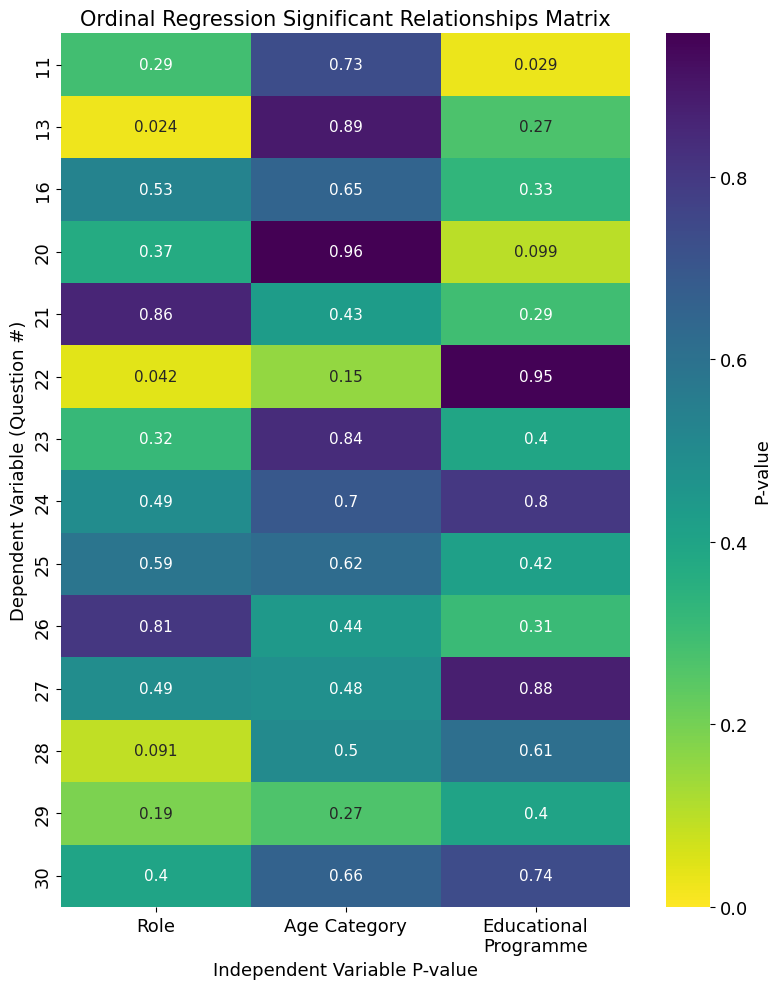

In [ ]:
dependent_variable_q_numbers = [11, 13, 16, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

independent_variable_indices = [q[1], q[2], q[33]]
indep_var_amount = len(independent_variable_indices)


independent_variable_names = ['Role', 'Age Category', 'Educational\nProgramme']

# Mapping q number to analysis result
analysis_dict = {11: res_log_a1, 13: res_log_a2, 16: res_log_a3, 20: res_log_a4, 21: res_log_a5, 22: res_log_a6,
23: res_log_a7,24: res_log_a8, 25: res_log_a9, 26: res_log_a10, 27: res_log_a11, 28: res_log_a12, 29: res_log_a13, 30: res_log_a14}


significance_matrix = pd.DataFrame(
    index=dependent_variable_q_numbers,
    columns=independent_variable_names,
    dtype=float
)


for dep_var_q_number in dependent_variable_q_numbers:
        res_log = analysis_dict[dep_var_q_number]
        indep_var_pvalue = res_log.pvalues[0:indep_var_amount]
        significance_matrix.loc[dep_var_q_number, independent_variable_names] = indep_var_pvalue


plt.figure(figsize=(8, 10))

sns.heatmap(significance_matrix, annot=True, annot_kws={"fontsize": 11},  cmap="viridis_r", cbar=True, vmin=0, cbar_kws={'label': 'P-value'})


plt.title('Ordinal Regression Significant Relationships Matrix', fontsize=15)
plt.xlabel('Independent Variable P-value', fontsize=13)
plt.ylabel('Dependent Variable (Question #)', fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=13)
cbar.ax.set_ylabel('P-value', fontsize=13)
plt.tight_layout()

plt.savefig('significance_matrix_pval0.05.png')
plt.savefig('significance_matrix_pval0.05.eps')

plt.show()



### Zooming in on significant analyses

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 1200x700 with 0 Axes>

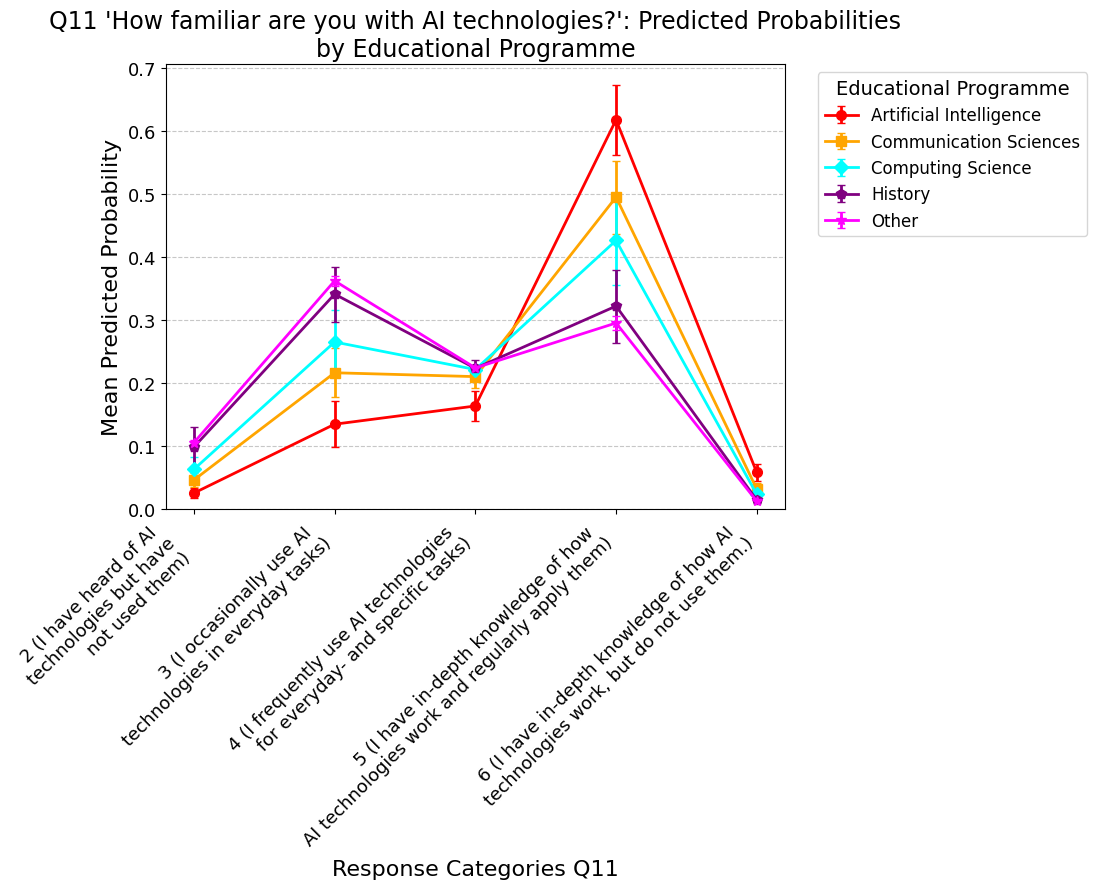

In [ ]:
cat = {'role': 1, 'age category': 2, 'educational programme': 3}
programme = {'Artificial Intelligence': 1, 'Communication Sciences': 2, 'Psychology': 3, 'Computing Science': 4, 'Pedagogical Sciences': 5, 'History': 6, 'Other': 7}
age_category = {'Young Adults': 0, 'Early Adults': 1, 'Adults': 2, 'Older Adults': 3}
role = {'teacher': 0, 'student': 1}
dep_var_a1_cat_labels = ['1 (I have no experience with AI technologies)', '2 (I have heard of AI \ntechnologies but have\nnot used them)', '3 (I occasionally use AI \n technologies in everyday tasks)', '4 (I frequently use AI technologies \n for everyday- and specific tasks)', '5 (I have in-depth knowledge of how \n AI technologies work and regularly apply them)', '6 (I have in-depth knowledge of how AI \n technologies work, but do not use them.)']


colors = ['Red', 'Orange', 'Green', 'Cyan', 'Yellow', 'Purple', 'Magenta']
markers = ['o', 's', '^', 'D', 'v', 'p', '*']


plt.figure(figsize=(12, 7))

pred_probs_q11 = res_log_a1.predict(exog=filtered_data_a1[:, 1:].astype(int))

actual_recoded_values_in_model = [1, 2, 3, 4, 5]

category_amount_in_model = pred_probs_q11.shape[1] #= 5, since option 0 was not chosen by any respondent



x_ticks = np.arange(category_amount_in_model)

current_plot_labels = [dep_var_a1_cat_labels[i] for i in actual_recoded_values_in_model]

plt.figure(figsize=(13, 9))

for i, (programme_name, programme_code) in enumerate(programme.items()):
    programme_mask = filtered_data_a1[:, cat['educational programme']] == programme_code

    if np.sum(programme_mask) > 0:
        prog_means = np.mean(pred_probs_q11[programme_mask], axis=0)
        prog_stds = np.std(pred_probs_q11[programme_mask], axis=0)

        if len(prog_means) == category_amount_in_model:
             plt.errorbar(x_ticks, prog_means, yerr=prog_stds, fmt=f'{markers[i % len(markers)]}-', color=colors[i], label=programme_name, capsize=3, markersize=7, linewidth=2)

plt.xlabel("Response Categories Q11", fontsize = 16)
plt.ylabel("Mean Predicted Probability", fontsize = 16)
plt.title("Q11 'How familiar are you with AI technologies?': Predicted Probabilities\nby Educational Programme", fontsize = 17)
plt.xticks(x_ticks, current_plot_labels, rotation=45, ha='right', fontsize = 13)
plt.yticks(fontsize=13)
plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left', title="Educational Programme", fontsize = 12, title_fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(bottom=0)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig('Q11_educational_programme_pred_probabilities.png')
plt.savefig('Q11_educational_programme_pred_probabilities.eps')
plt.show()



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


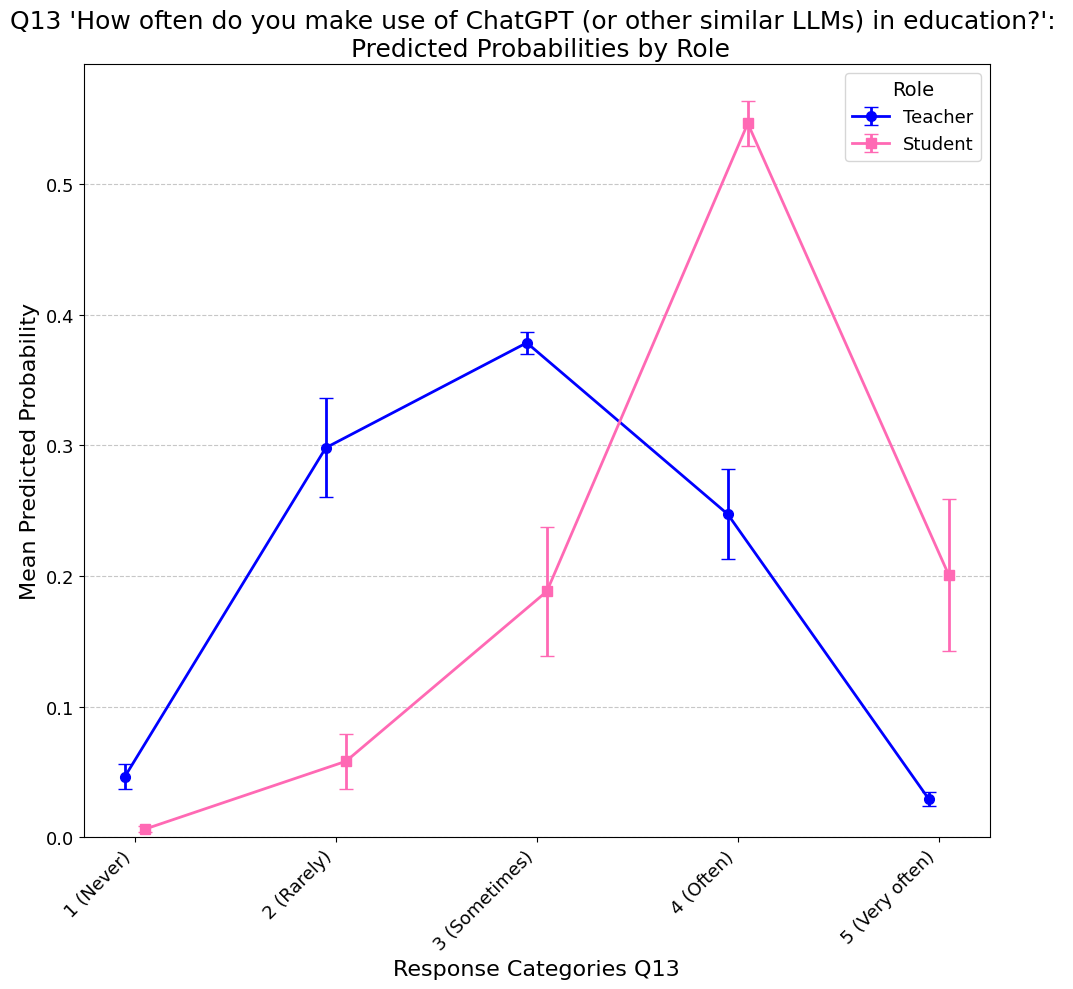

In [ ]:
dep_var_a2_cat_labels = ['1 (Never)', '2 (Rarely)', '3 (Sometimes)', '4 (Often)', '5 (Very often)']

role_colors = {role['teacher']: 'blue', role['student']: 'hotpink'}
role_markers = {role['teacher']: 'o', role['student']: 's'}
role_labels = {v: k for k, v in role.items()}


pred_probs_q13 = res_log_a2.predict(exog=filtered_data_a2[:, 1:].astype(int))
category_amount_in_model = pred_probs_q13.shape[1]
current_plot_labels = dep_var_a2_cat_labels

x_ticks = np.arange(category_amount_in_model)

plt.figure(figsize=(10, 10))

teacher_code = role['teacher']
teacher_mask = filtered_data_a2[:, cat['role']] == teacher_code
teacher_means = np.mean(pred_probs_q13[teacher_mask], axis=0)
teacher_stds = np.std(pred_probs_q13[teacher_mask], axis=0)
plt.errorbar(x_ticks - 0.05, teacher_means, yerr=teacher_stds, fmt=f'{role_markers[teacher_code]}-', color=role_colors[teacher_code], label=role_labels[teacher_code].capitalize(), capsize=5, markersize=7, linewidth=2)

student_code = role['student']
student_mask = filtered_data_a2[:, cat['role']] == student_code
student_means = np.mean(pred_probs_q13[student_mask], axis=0)
student_stds = np.std(pred_probs_q13[student_mask], axis=0)
plt.errorbar(x_ticks + 0.05, student_means, yerr=student_stds, fmt=f'{role_markers[student_code]}-', color=role_colors[student_code], label=role_labels[student_code].capitalize(), capsize=5, markersize=7, linewidth=2)

plt.xlabel("Response Categories Q13", fontsize = 16)
plt.ylabel("Mean Predicted Probability", fontsize = 16)
plt.title("Q13 'How often do you make use of ChatGPT (or other similar LLMs) in education?': \n Predicted Probabilities by Role", fontsize = 18)
plt.xticks(x_ticks, current_plot_labels, fontsize = 13, rotation=45, ha='right')
plt.yticks(fontsize=13)
plt.legend(title="Role", fontsize=13, title_fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(bottom=0)
plt.tight_layout()
plt.savefig('Q13_role_pred_probabilities.png')
plt.savefig('Q13_role_pred_probabilities.eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


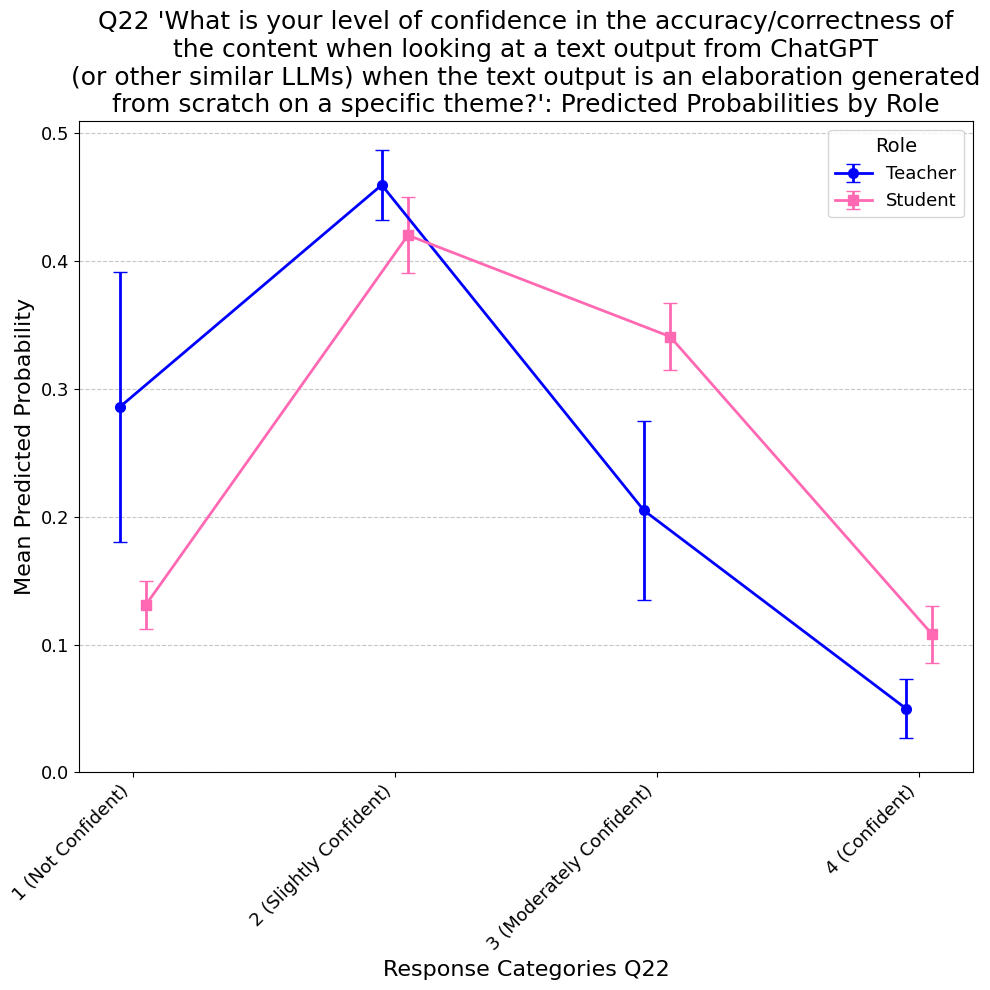

In [ ]:
dep_var_a6_cat_labels = ['1 (Not Confident)', '2 (Slightly Confident)', '3 (Moderately Confident)', '4 (Confident)', '5 (Very Confident)']


role_colors = {role['teacher']: 'blue', role['student']: 'hotpink'}
role_markers = {role['teacher']: 'o', role['student']: 's'}
role_labels = {v: k for k, v in role.items()}


pred_probs_q22 = res_log_a6.predict(exog=filtered_data_a6[:, 1:].astype(int))
category_amount_in_model = pred_probs_q22.shape[1]
current_plot_labels = dep_var_a6_cat_labels[:category_amount_in_model]

x_ticks = np.arange(category_amount_in_model)

plt.figure(figsize=(10, 10))

teacher_code = role['teacher']
teacher_mask = filtered_data_a6[:, cat['role']] == teacher_code
teacher_means = np.mean(pred_probs_q22[teacher_mask], axis=0)
teacher_stds = np.std(pred_probs_q22[teacher_mask], axis=0)
plt.errorbar(x_ticks - 0.05, teacher_means, yerr=teacher_stds, fmt=f'{role_markers[teacher_code]}-', color=role_colors[teacher_code], label=role_labels[teacher_code].capitalize(), capsize=5, markersize=7, linewidth=2)

student_code = role['student']
student_mask = filtered_data_a6[:, cat['role']] == student_code
student_means = np.mean(pred_probs_q22[student_mask], axis=0)
student_stds = np.std(pred_probs_q22[student_mask], axis=0)
plt.errorbar(x_ticks + 0.05, student_means, yerr=student_stds, fmt=f'{role_markers[student_code]}-', color=role_colors[student_code], label=role_labels[student_code].capitalize(), capsize=5, markersize=7, linewidth=2)

plt.xlabel("Response Categories Q22", fontsize = 16)
plt.ylabel("Mean Predicted Probability", fontsize = 16)
plt.title("Q22 'What is your level of confidence in the accuracy/correctness of\nthe content when looking at a text output from ChatGPT\n(or other similar LLMs) when the text output is an elaboration generated\nfrom scratch on a specific theme?': Predicted Probabilities by Role", fontsize = 18)
plt.xticks(x_ticks, current_plot_labels, fontsize = 13, rotation=45, ha='right')
plt.yticks(fontsize = 13)
plt.legend(title="Role", fontsize=13, title_fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(bottom=0)
plt.tight_layout()
plt.savefig('Q22_role_pred_probabilities.png')
plt.savefig('Q22_role_pred_probabilities.eps')
plt.show()

## **Results when p-value < 0.1**

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


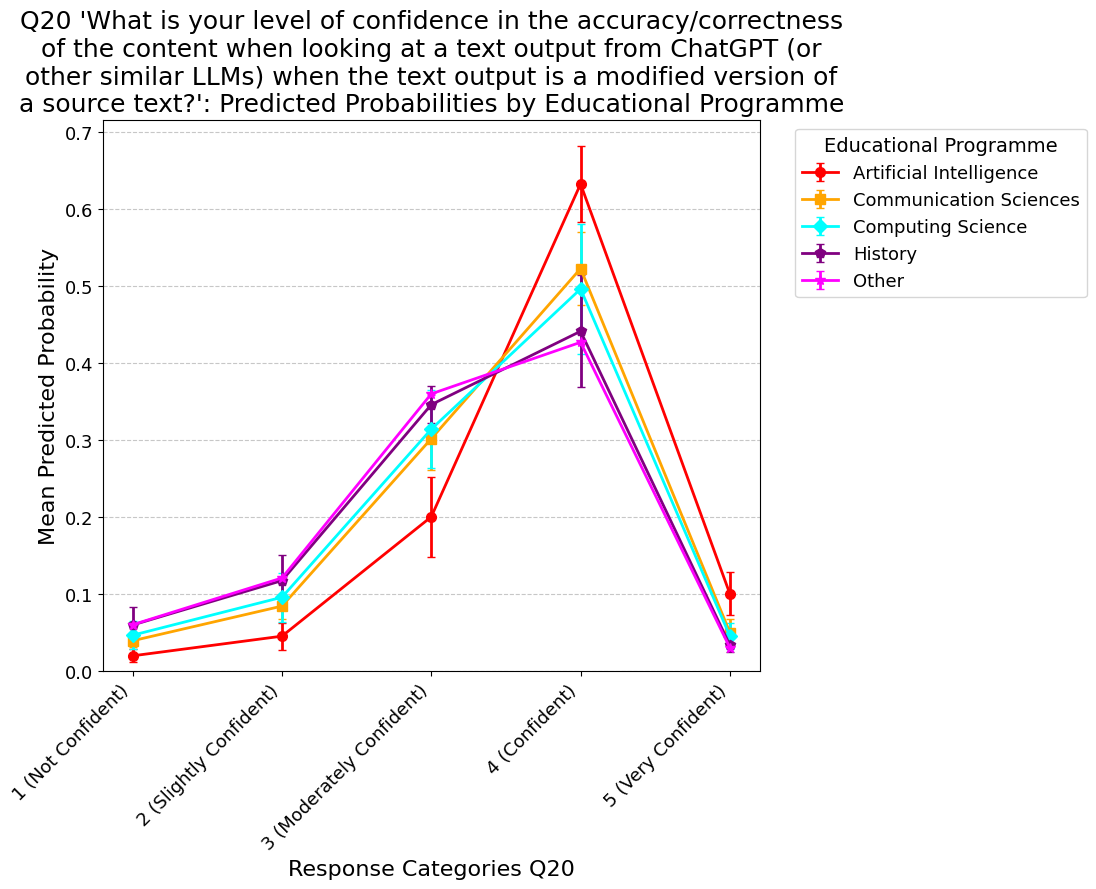

In [ ]:
dep_var_a4_cat_labels = ['1 (Not Confident)', '2 (Slightly Confident)', '3 (Moderately Confident)', '4 (Confident)', '5 (Very Confident)']

colors = ['Red', 'Orange', 'Green', 'Cyan', 'Yellow', 'Purple', 'Magenta']
markers = ['o', 's', '^', 'D', 'v', 'p', '*']

pred_probs_q20 = res_log_a4.predict(exog=filtered_data_a4[:, 1:].astype(int))
category_amount_in_model = pred_probs_q20.shape[1]

current_plot_labels = dep_var_a4_cat_labels[:category_amount_in_model]

x_ticks = np.arange(category_amount_in_model)

plt.figure(figsize=(13, 9))

for i, (programme_name, programme_code) in enumerate(programme.items()):
    programme_mask = filtered_data_a4[:, cat['educational programme']] == programme_code
    if np.sum(programme_mask) > 0:
        prog_means = np.mean(pred_probs_q20[programme_mask], axis=0)
        prog_stds = np.std(pred_probs_q20[programme_mask], axis=0)

        if len(prog_means) == category_amount_in_model:
            plt.errorbar(x_ticks, prog_means, yerr=prog_stds, fmt=f'{markers[i % len(markers)]}-', color=colors[i], label=programme_name, capsize=3, markersize=7, linewidth=2)

plt.xlabel("Response Categories Q20", fontsize = 16)
plt.ylabel("Mean Predicted Probability", fontsize = 16)
plt.title("Q20 'What is your level of confidence in the accuracy/correctness\nof the content when looking at a text output from ChatGPT (or\nother similar LLMs) when the text output is a modified version of\na source text?': Predicted Probabilities by Educational Programme", fontsize = 18)
plt.xticks(x_ticks, current_plot_labels, fontsize = 13, rotation=45, ha='right')
plt.yticks(fontsize = 13)
plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left', title="Educational Programme", fontsize=13, title_fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(bottom=0)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig('Q20_educational_programme_pred_probabilities.png')
plt.savefig('Q20_educational_programme_pred_probabilities.eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


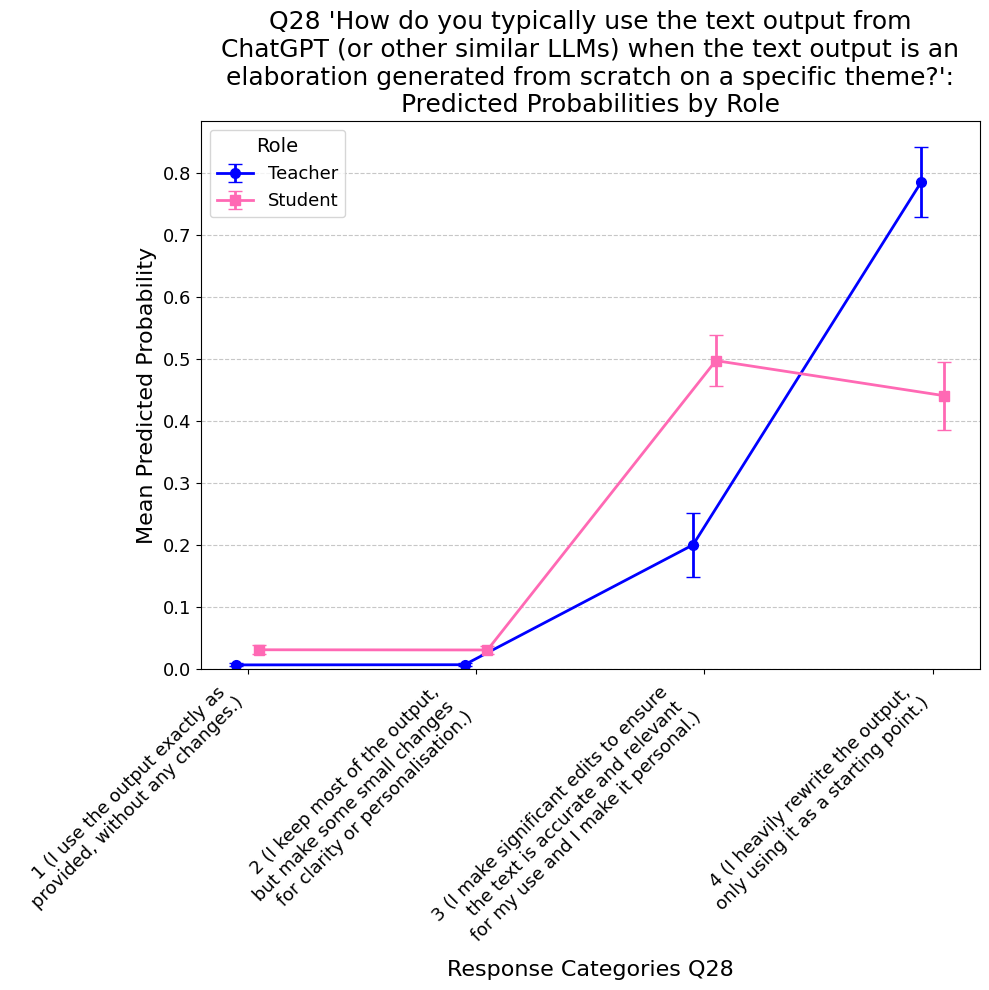

In [ ]:
dep_var_a12_cat_labels = ['1 (I use the output exactly as \n provided, without any changes.)', '2 (I keep most of the output, \n but make some small changes \n for clarity or personalisation.)', '3 (I make significant edits to ensure \n the text is accurate and relevant \n for my use and I make it personal.)', '4 (I heavily rewrite the output, \n only using it as a starting point.)']

colors = plt.cm.tab10(np.linspace(0, 1, len(role)))

role_colors = {role['teacher']: 'blue', role['student']: 'hotpink'}
role_markers = {role['teacher']: 'o', role['student']: 's'}
role_labels = {v: k for k, v in role.items()}

pred_probs_q28 = res_log_a12.predict(exog=filtered_data_a12[:, 1:].astype(int))
category_amount_in_model = pred_probs_q28.shape[1]
current_plot_labels = dep_var_a12_cat_labels

x_ticks = np.arange(category_amount_in_model)

plt.figure(figsize=(10, 10))

teacher_code = role['teacher']
teacher_mask = filtered_data_a12[:, cat['role']] == teacher_code
teacher_means = np.mean(pred_probs_q28[teacher_mask], axis=0)
teacher_stds = np.std(pred_probs_q28[teacher_mask], axis=0)
plt.errorbar(x_ticks - 0.05, teacher_means, yerr=teacher_stds, fmt=f'{role_markers[teacher_code]}-', color=role_colors[teacher_code], label=role_labels[teacher_code].capitalize(), capsize=5, markersize=7, linewidth=2)

student_code = role['student']
student_mask = filtered_data_a12[:, cat['role']] == student_code
student_means = np.mean(pred_probs_q28[student_mask], axis=0)
student_stds = np.std(pred_probs_q28[student_mask], axis=0)
plt.errorbar(x_ticks + 0.05, student_means, yerr=student_stds, fmt=f'{role_markers[student_code]}-', color=role_colors[student_code], label=role_labels[student_code].capitalize(), capsize=5, markersize=7, linewidth=2)

plt.xlabel("Response Categories Q28", fontsize = 16)
plt.ylabel("Mean Predicted Probability", fontsize = 16)
plt.title("Q28 'How do you typically use the text output from\nChatGPT (or other similar LLMs) when the text output is an\nelaboration generated from scratch on a specific theme?':\nPredicted Probabilities by Role", fontsize = 18)
plt.xticks(x_ticks, current_plot_labels, fontsize = 13, rotation=45, ha='right')
plt.yticks(fontsize = 13)
plt.legend(title="Role", fontsize=13, title_fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(bottom=0)
plt.tight_layout()
plt.savefig('Q28_role_pred_probabilities.png')
plt.savefig('Q28_role_pred_probabilities.eps')
plt.show()